## Table of Contents

* [1. Introduction](#introduction)
    * [1.1 Background of Trackd](#background-of-trackd)
    * [1.2 Data Source](#data-source)
* [2. Data Exploration](#data-exploring)
    * [2.1 Looking into accounts: Basic information of user](#users)
    * [2.2 Behind the Music: Investigating the Song Creators](#song-creators)
* [3. Segmentation by PCA and Unsupervised-learning methods](#segmentation)
    * [3.1 Data Wrangling](#data-wrangling)
    * [3.2 Dimensionality Reduction using Principal Component Analysis (PCA)](#pca)
    * [3.3 Clustering by K-mean and DBSCAN](#cluster)
    * [3.4 Exploring the segmentation attributes](#segmentation-attributes)    
* [4. Conclusion](#conclusion)
* [5. Reference](#reference)

Import and install required packages 

In [1]:
!pip install psycopg2
!pip install -U kaleido
import psycopg2 as pg
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sqlalchemy import create_engine
from matplotlib.pyplot import figure
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from geopy.geocoders import Nominatim
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression


#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import psycopg2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")
import numpy as np
import seaborn as sns
import matplotlib as mpl
import plotly.express as px
import plotly.graph_objects as go
import datetime

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)


Connect database to pull data, please change the detail below to run the notebook.

In [3]:
engine = create_engine("postgresql://rachel@localhost/rachel")
conn = psycopg2.connect(
    host="localhost",
    port='5432',
    database="postgres",
    user="rachel",
    password="    ")


Define the fuctions

In [4]:
def null_count(df):
    return df.isna().sum()#.to_dict()

def check_null_percantage(df,column):
    return round(sum(df[column].isnull())/len(df),2)

def check_empty_string(df,column):
    return round(sum(df[column]=="")/len(df),2)

def check_empty_dict(df,column):
    return sum(df[column]=={})

def category_value(df, column):
    return round(df[column].value_counts()/len(df),2)

# 1. Introduction <a class="anchor" id="introduction"></a>

## 1.1 Background of Trackd <a class="anchor" id="background-of-trackd"></a>

Technology has transformed the music industry massively. Digitalisation allowed more individuals to pursue a music production career. It led to increase competition in the music industry. Trackd Limited leveraged this opportunity and developed an innovative streaming platform to support young artists by promoting collaboration between artists and donation support by fans. Yet, in a highly competitive market, Trackd Limited still seeks a data-driven approach to stay competitive. 

## 1.2 Data Source <a class="anchor" id="data-source"></a>

The database that contains xxx datasets was provided directly from Trackd in order to examine the company’s performance in greater detail since the application was launched. 

# 2. Data Exploration <a class="anchor" id="data-exploring"></a>

Store the selected tables to variables

In [5]:
# user side overall
auth_user = pd.read_sql('select * from auth_user', con=conn)
users_userprofile = pd.read_sql('select * from users_userprofile', con=conn)
users_userlocation = pd.read_sql('select * from users_userlocation', con=conn)
marketing_deeplink = pd.read_sql('select * from marketing_deeplink', con=conn)
users_registrationcountry = pd.read_sql('select * from users_registrationcountry', con=conn)
chipin_transaction = pd.read_sql('select chipin_transaction.made_by_id, chipin_transaction.made_for_id, chipin_transaction.amount, chipin_transaction.status, chipin_transaction.currency, chipin_transaction.product_type from chipin_transaction', con=conn)
chipin_subscription = pd.read_sql('select chipin_subscription.made_by_id, chipin_subscription.made_for_id, chipin_subscription.amount, chipin_subscription.status, chipin_subscription.currency, chipin_subscription.product_type from chipin_subscription', con=conn)

# creator side related data 
studio_song = pd.read_sql('select * from studio_song', con=conn)
discover_genres = pd.read_sql('select * from discover_genres', con=conn)

## 2.1 Looking into accounts: Basic information of user <a class="anchor" id="background-of-trackd"></a>

Looking into accounts involves examining the basic information of a user, such as gender, age, and subscription type. This process is important for understanding the user behavior and how they may interact with the platform, and can provide valuable insights for improving the company business model and marketing strategy.

### users_userprofile

This file includes the crutial information of user_id, gender, user_type and chipin_account_type. Exploration was done to analyse the gender distribution, age distribution, user type, and the distribution of chipin_account_type.

Basic overview of the users_userprofile data.

In [6]:
users_userprofile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17978 entries, 0 to 17977
Data columns (total 70 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           17978 non-null  int64  
 1   name                         7024 non-null   object 
 2   gender                       15270 non-null  object 
 3   date_of_birth                9770 non-null   object 
 4   photo                        17978 non-null  object 
 5   cover_photo                  17978 non-null  object 
 6   site                         6483 non-null   object 
 7   phone                        231 non-null    object 
 8   occupation                   225 non-null    object 
 9   facebook                     11332 non-null  object 
 10  instagram                    11340 non-null  object 
 11  snapchat                     11225 non-null  object 
 12  bio                          6625 non-null   object 
 13  timestamp       

Understand the gender distribution of the gender in users.

In [7]:
#check unique value
gender_values = users_userprofile['gender'].unique()

print("Unique gender values:", gender_values)

# Each Unique value percentage
gender_counts = users_userprofile['gender'].value_counts(normalize=True)

print("Percentage of each gender value:")
print(gender_counts * 100)


# bar graph of user's gender
# Calculate the percentages for male, female, and other gender values
male_pct = gender_counts['male'] * 100
female_pct = gender_counts['female'] * 100
other_pct = (100 - (male_pct+female_pct))

# Create a bar plot
fig, ax = plt.subplots()
ax.bar(['Male', 'Female', 'Other'], [male_pct, female_pct, other_pct],color='#2faedc')
ax.set_ylabel('Percentage')
ax.set_title('Gender Distribution')
plt.show()

Unique gender values: ['male' 'female' None '' 'unknown']
Percentage of each gender value:
male       40.478062
           27.806156
female     23.051735
unknown     8.664047
Name: gender, dtype: float64


Understand the age distribution of users.

In [8]:
# drop data 1053-08-30 (outlier, might be error)
users_userprofile = users_userprofile.loc[pd.to_datetime(users_userprofile['date_of_birth'], errors='coerce').notna()]

#count the age by date_of_birth
#the data was given around the beginning of 2023; thus,the age is counted from 2023
current_year = 2023
users_userprofile['age'] = current_year - pd.to_datetime(users_userprofile['date_of_birth']).dt.year

age_counts = users_userprofile['age'].value_counts().sort_index()
age_labels = ['{}-{}'.format(i, i+9) for i in range(0, 100, 10)]
age_labels[-1] = '>=90'
age_counts_binned = pd.cut(users_userprofile['age'], bins=[i for i in range(0, 101, 10)], right=False).value_counts(sort=False)

# Create a bar plot
fig, ax = plt.subplots()
ax.bar(age_labels, age_counts_binned,color='#2faedc')
ax.set_xlabel('Age Range')
ax.set_ylabel('Number of Individuals')
ax.set_title('Age Distribution')
plt.xticks(rotation=45, ha='right')
plt.show()

When a new account is created, users are given the option to choose between "Creator" and "Discover" identities, which can be switched within the system at a later time. The assumption is made here that the data recorded user's first choice, and representing the initial motivation of users.

Creator percentage: 69.84%
Discover percentage: 27.22%
Non-missing value percentage: 97.06%


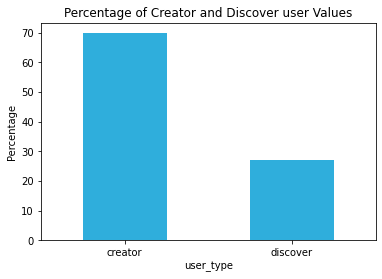

In [9]:
#percentage of creator and discover
gender_counts = users_userprofile['user_type'].value_counts(normalize=True)

creator_percentage = gender_counts['creator'] * 100
discover_percentage = gender_counts['discover'] * 100
non_missing_percentage = creator_percentage + discover_percentage

print('Creator percentage: {:.2f}%'.format(creator_percentage))
print('Discover percentage: {:.2f}%'.format(discover_percentage))
print('Non-missing value percentage: {:.2f}%'.format(non_missing_percentage))

# Create a bar plot
user_type_percentages = pd.Series([creator_percentage, discover_percentage],
                               index=['creator', 'discover'])

# Create a bar graph
fig, ax = plt.subplots()
user_type_percentages.plot.bar(ax=ax, color='#2faedc')
ax.set_xlabel('user_type')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Creator and Discover user Values')
ax.set_xticklabels(user_type_percentages.index, rotation=0)

plt.show()



To look into more detail of the "Creator" and "Discover", the exploration of the differences in ages is as below.

In [10]:
grouped = users_userprofile.groupby('user_type')

# Extract DataFrames for each user type
creator_df = grouped.get_group('creator')
discover_df = grouped.get_group('discover')

# drop data 1053-08-30 (outlier, might be error)
#creator_df

creator_df = creator_df.loc[pd.to_datetime(creator_df['date_of_birth'], errors='coerce').notna()]

#count the age by date_of_birth
#the data was given around the beginning of 2023; thus,the age is counted from 2023
current_year = 2023
creator_df['age'] = current_year - pd.to_datetime(creator_df['date_of_birth']).dt.year

age_counts = creator_df['age'].value_counts().sort_index()
age_labels = ['{}-{}'.format(i, i+9) for i in range(0, 100, 10)]
age_labels[-1] = '>=90'
age_counts_binned = pd.cut(creator_df['age'], bins=[i for i in range(0, 101, 10)], right=False).value_counts(sort=False)

# drop data 1053-08-30 (outlier, might be error)
#discover_df
discover_df = discover_df.loc[pd.to_datetime(discover_df['date_of_birth'], errors='coerce').notna()]

#count the age by date_of_birth
#the data was given around the beginning of 2023; thus,the age is counted from 2023

current_year = 2023
discover_df['age'] = current_year - pd.to_datetime(discover_df['date_of_birth']).dt.year

age_counts = discover_df['age'].value_counts().sort_index()
age_labels = ['{}-{}'.format(i, i+9) for i in range(0, 100, 10)]
age_labels[-1] = '>=90'
age_counts_binned2 = pd.cut(discover_df['age'], bins=[i for i in range(0, 101, 10)], right=False).value_counts(sort=False)

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 5))

# Create the two bars, one for 'creator' and one for 'discover', and set the color of each bar
bar1 = ax.bar(age_labels, age_counts_binned, color='#2faedc', alpha=0.7)
bar2 = ax.bar(age_labels, age_counts_binned2, color='#FF0032', alpha=0.7)

ax.set_xlabel('Age Range')
ax.set_ylabel('Number of Individuals')
ax.set_title('Age Distribution by User Type')

# Add a legend to show which color corresponds to each user type
ax.legend([bar1, bar2], ['Creator', 'Discover'])

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

In Trackd Limited's business model, creators can choose to subscribe the Chipin or Chipin Plus package to gain benefit from Trickd platform and earn donations from fans. Since the identities can be switch between "Creator" and "Discover", all users' subscrition type is counted in below distribution.

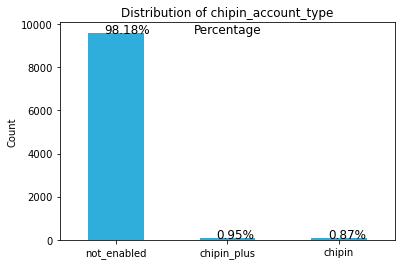

In [11]:
# Get unique values of chipin_account_type and their counts
value_counts = users_userprofile['chipin_account_type'].value_counts()

# Create a new figure
fig, ax = plt.subplots()

# Create a bar chart of the value counts with percentages on the y-axis
value_counts.plot(kind='bar', ax=ax, color='#2faedc')

# Add text labels for the percentage of each value count
totals = []
for i in ax.patches:
    totals.append(i.get_height())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_x()+.15, i.get_height()+.5, str(round((i.get_height()/total)*100, 2))+'%', fontsize=12, color='black')

# Customize the plot
ax.set_ylabel('Count')
ax.set_title('Distribution of chipin_account_type')
ax.set_xticklabels(value_counts.index, rotation=0)
ax.text(0.5, 0.95, 'Percentage', transform=ax.transAxes, ha='center', fontsize=12)
plt.show()

### chipin related

Trackd's profit model is based on two primary sources: artist subscriptions through Chipin and Chipin Plus, and commission from fan donations based on the artist's chosen subscription method. Chipin subscribers receive 95% of fan donations, while Chipin Plus subscribers receive 85% but can lock content behind a specific donation amount, creating a fans-only section. 

After understanding the company's revenue stream, we further explored the overall profit of Trackd Limited from fan donations and the contributors to gain insights into earnings. The analysis was performed separately on two files, chipin_subscription and chipin_transaction, under the assumption that they were separate and that donations from prices did not duplicate in both files.

In [12]:
#merge file to match up the user detail from auth_user
chip_sub = auth_user.merge(chipin_subscription, left_on='id', right_on='made_by_id')    

In chipin_subscription, subscriptions are defined in three status. The percentage of each status is calculated below.

In [13]:
# Get unique values of status and their counts
value_counts = chip_sub['status'].value_counts()

# Calculate percentages of each status
total_count = value_counts.sum()
value_pct = [round(count / total_count * 100, 2) for count in value_counts]

# Create a bar graph of the value counts with percentage labels
fig, ax = plt.subplots()
bars = ax.bar(value_counts.index, value_counts.values, color='#2faedc')
ax.set_xlabel('Status')
ax.set_ylabel('Count')
ax.set_title('Value Counts of Status in chipin_subscription')

# Add percentage labels to the bars
for i, bar in enumerate(bars):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{value_pct[i]}%", ha='center', va='bottom')

# Save the bar graph as a PNG image
# fig.savefig('/Users/chingyuhsieh/test/Predictive/Group/my_figure.png/sub_status_value_counts.png')

# Display the bar graph
plt.show()

Subscrptions are made in three currencies, USD, EUR, and GBP. Exploration is made to understand the total amount Trackd Limited earn from fans donation, the percentage Trackd Limited get from Chipin and Chipin Plus is different.

In [14]:
# droped cancelled row
sub_no_cancelled = chip_sub[chip_sub['status'] != 'cancelled']

In [15]:
#chipin Trackd earn amount*0.05
#chipin plus Trakd earn amount*0.15

grouped_df = sub_no_cancelled.groupby(['product_type', 'currency'])['amount'].sum()
sum_by_currency_df = grouped_df.reset_index()
sum_by_currency_df['Trackd earn'] = sum_by_currency_df.apply(lambda row: row['amount']*0.05 if row['product_type'] == 'chipin' else row['amount']*0.15 if row['product_type'] == 'chipin_plus' else 0, axis=1)
print(sum_by_currency_df)

#total earn for Trackd from subscription
earned_by_currency = sum_by_currency_df.groupby('currency')['Trackd earn'].sum()
print("Trackd earn by currency: \n", earned_by_currency)

  product_type currency   amount  Trackd earn
0       chipin      eur   1000.0        50.00
1       chipin      gbp  26900.0      1345.00
2       chipin      usd  18500.0       925.00
3  chipin_plus      gbp   1981.0       297.15
4  chipin_plus      usd   1498.0       224.70
Trackd earn by currency: 
 currency
eur      50.00
gbp    1642.15
usd    1149.70
Name: Trackd earn, dtype: float64


In [16]:
# Group the data by currency and calculate the sum of Trackd earn
earned_by_currency = sum_by_currency_df.groupby('currency')['Trackd earn'].sum()

# Create a horizontal bar chart of the Trackd earn by currency
fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(earned_by_currency.index, earned_by_currency.values, height=0.5)

# Add the values to the bars
for i, v in enumerate(earned_by_currency.values):
    ax.text(v, i, str(round(v, 2)), color='black', ha='center', va='top',
           bbox=dict(facecolor='white',alpha=0.8, edgecolor='white', boxstyle='round,pad=0.4'))

# Set the axis labels and title
ax = earned_by_currency.plot(kind='barh', color='#2faedc')
ax.set_xlabel('Trackd earn',)
ax.set_ylabel('Currency')
ax.set_title('Trackd earn by Currency - Subscription')

# Set the linewidth of the spines to 2
for spine in ax.spines.values():
    spine.set_linewidth(0.5)

plt.show()


To understand the constitution of fans that donate, the number of users that made donation and the percentage is explored as below.

In [17]:
# Get unique values of chipin_account_type and their counts
value_counts = sub_no_cancelled['made_by_id'].value_counts()


print("Number of unique ID in subscription: ", len(value_counts))
# print(value_counts)

Number of unique ID in subscription:  24


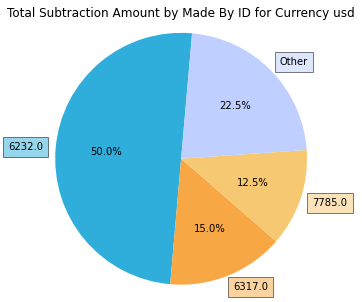

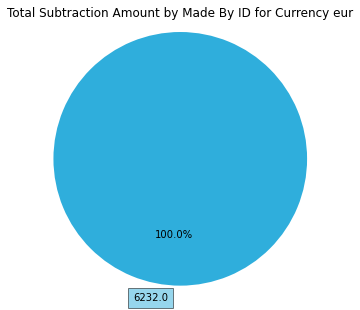

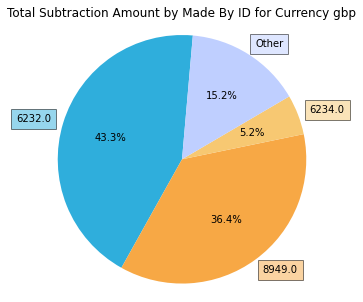

In [18]:
# Group the data by 'made_by_id', 'currency', and 'product_type' and calculate the sum of 'amount' for each group
grouped_data = sub_no_cancelled.groupby(['made_by_id', 'currency', 'product_type'])['amount'].sum()

# Convert the resulting Series to a DataFrame and reset the index
df_grouped = grouped_data.to_frame().reset_index()

for currency in ['usd', 'eur', 'gbp']:
    # Filter the DataFrame to only include rows with the current currency
    currency_data = df_grouped[df_grouped['currency'] == currency]

    # Get the values for the labels and the sizes of the pie chart
    labels = currency_data['made_by_id'].tolist()
    sizes = currency_data['amount'].tolist()

    # Sort the labels and sizes in descending order
    sorted_data = sorted(zip(labels, sizes), key=lambda x: x[1], reverse=True)
    sorted_labels = [x[0] for x in sorted_data]
    sorted_sizes = [x[1] for x in sorted_data]

    # Get the top three labels and sizes
    top_labels = sorted_labels[:3]
    top_sizes = sorted_sizes[:3]

    # Get the size of the "other" category
    other_size = sum(sorted_sizes[3:])

       # Add the "other" category to the list of sizes and labels
    if other_size > 0:
        top_labels.append("Other")
        top_sizes.append(other_size)

    # If there's no "other" category, remove it from the labels and sizes lists
    if "Other" in top_labels and other_size == 0:
        idx = top_labels.index("Other")
        top_labels.pop(idx)
        top_sizes.pop(idx)

    # Set the colors for the pie chart
    colors = ['#2faedc', '#f7a845', '#f7c872', '#bfcfff']

    # Create the pie chart
    fig, ax = plt.subplots(figsize=(5, 5))
    wedges, labels, _ = ax.pie(top_sizes, colors=colors, autopct='%1.1f%%', startangle=85, labels=top_labels)
    for label, color in zip(labels, colors):
        label.set_bbox({'facecolor': color, 'alpha': 0.5, 'pad': 5})
    ax.axis('equal')
    ax.set_title('Total Subtraction Amount by Made By ID for Currency ' + currency)

    # Show the pie chart
    plt.show()

    # Set the labels for the top three wedges
    for i, label in enumerate(labels):
        if label.get_text() in top_labels:
            # Get the index of the current label
            idx = top_labels.index(label.get_text())

            # Set the text for the label to include the made_by_id and the percentage
            label.set_text(f'{top_labels[idx]}: {top_sizes[idx]:.1f}%')

            # Set the color for the label to match the color of the corresponding wedge
            label.set_color(colors[idx])

    # Show the pie chart with updated labels
    plt.show()

Same steps of exploration are done on chipin_transaction as chipin_subscription.

In [19]:
#merge file
chip_tran = auth_user.merge(chipin_transaction, left_on='id', right_on='made_by_id')

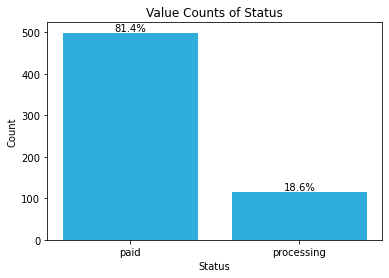

In [20]:
# Get unique values of status and their counts
value_counts = chip_tran['status'].value_counts()

# Calculate percentages of each status
total_count = value_counts.sum()
value_pct = [round(count / total_count * 100, 2) for count in value_counts]

# Create a bar graph of the value counts
fig, ax = plt.subplots()
bars = ax.bar(value_counts.index, value_counts.values, color='#2faedc')

# Set the labels for the x-axis and y-axis
ax.set_xlabel('Status')
ax.set_ylabel('Count')

# Set the title of the graph
ax.set_title('Value Counts of Status')

# Add percentage labels to the bars
for i, bar in enumerate(bars):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{value_pct[i]}%", ha='center', va='bottom')

# Display the bar graph
plt.show()

In [21]:
grouped_df = chip_tran.groupby(['product_type', 'currency'])['amount'].sum()
sum_by_currency_df = grouped_df.reset_index()

sum_by_currency_df['Trackd earn'] = sum_by_currency_df.apply(lambda row: row['amount']*0.05 if row['product_type'] == 'chipin' else row['amount']*0.15 if row['product_type'] == 'chipin_plus' else 0, axis=1)
print(sum_by_currency_df)
#total earn for Trackd from subscription
earned_by_currency = sum_by_currency_df.groupby('currency')['Trackd earn'].sum()
print("Trackd earn by currency: \n", earned_by_currency)

  product_type currency    amount  Trackd earn
0       chipin      eur    6100.0       305.00
1       chipin      gbp  177667.0      8883.35
2       chipin      usd   87255.0      4362.75
3  chipin_plus      gbp   72673.0     10900.95
4  chipin_plus      usd     199.0        29.85
Trackd earn by currency: 
 currency
eur      305.0
gbp    19784.3
usd     4392.6
Name: Trackd earn, dtype: float64


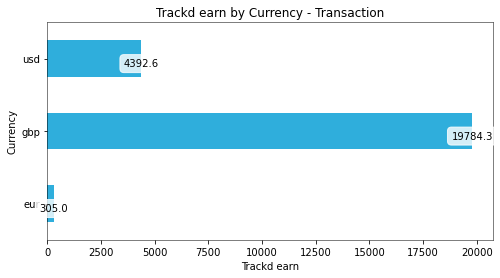

In [22]:
# Group the data by currency and calculate the sum of Trackd earn
earned_by_currency = sum_by_currency_df.groupby('currency')['Trackd earn'].sum()

# Create a horizontal bar chart of the Trackd earn by currency
fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(earned_by_currency.index, earned_by_currency.values, height=0.5)

# Add the values to the bars
for i, v in enumerate(earned_by_currency.values):
    ax.text(v, i, str(round(v, 2)), color='black', ha='center', va='top',
           bbox=dict(facecolor='white',alpha=0.8, edgecolor='white', boxstyle='round,pad=0.4'))

# Set the axis labels and title
ax = earned_by_currency.plot(kind='barh', color='#2faedc')
ax.set_xlabel('Trackd earn',)
ax.set_ylabel('Currency')
ax.set_title('Trackd earn by Currency - Transaction')

# Set the linewidth of the spines to 2
for spine in ax.spines.values():
    spine.set_linewidth(0.5)

plt.show()



In [23]:
# Get unique values of chipin_account_type and their counts
value_counts = chip_tran['made_by_id'].value_counts()

print("Number of unique ID in subscription: ", len(value_counts))

Number of unique ID in subscription:  50


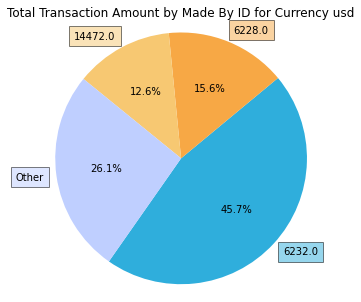

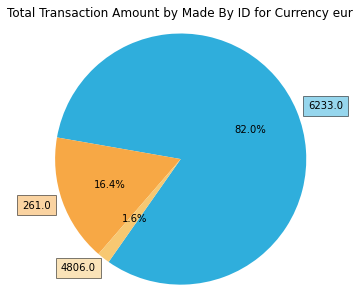

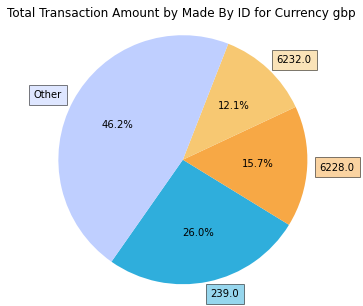

In [24]:
# Group the data by 'made_by_id', 'currency', and 'product_type' and calculate the sum of 'amount' for each group
grouped_data = chip_tran.groupby(['made_by_id', 'currency', 'product_type'])['amount'].sum()

# Convert the resulting Series to a DataFrame and reset the index
df_grouped = grouped_data.to_frame().reset_index()

for currency in ['usd', 'eur', 'gbp']:
    # Filter the DataFrame to only include rows with the current currency
    currency_data = df_grouped[df_grouped['currency'] == currency]

    # Get the values for the labels and the sizes of the pie chart
    labels = currency_data['made_by_id'].tolist()
    sizes = currency_data['amount'].tolist()

    # Sort the labels and sizes in descending order
    sorted_data = sorted(zip(labels, sizes), key=lambda x: x[1], reverse=True)
    sorted_labels = [x[0] for x in sorted_data]
    sorted_sizes = [x[1] for x in sorted_data]

    # Get the top three labels and sizes
    top_labels = sorted_labels[:3]
    top_sizes = sorted_sizes[:3]

    # Get the size of the "other" category
    other_size = sum(sorted_sizes[3:])

       # Add the "other" category to the list of sizes and labels
    if other_size > 0:
        top_labels.append("Other")
        top_sizes.append(other_size)

    # If there's no "other" category, remove it from the labels and sizes lists
    if "Other" in top_labels and other_size == 0:
        idx = top_labels.index("Other")
        top_labels.pop(idx)
        top_sizes.pop(idx)

    # Set the colors for the pie chart
    colors = ['#2faedc', '#f7a845', '#f7c872', '#bfcfff']

    # Create the pie chart
    fig, ax = plt.subplots(figsize=(5, 5))
    wedges, labels, _ = ax.pie(top_sizes, colors=colors, autopct='%1.1f%%', startangle=235, labels=top_labels)
    for label, color in zip(labels, colors):
        label.set_bbox({'facecolor': color, 'alpha': 0.5, 'pad': 5})
    ax.axis('equal')
    ax.set_title('Total Transaction Amount by Made By ID for Currency ' + currency)

    # Show the pie chart
    plt.show()

    # Set the labels for the top three wedges
    for i, label in enumerate(labels):
        if label.get_text() in top_labels:
            # Get the index of the current label
            idx = top_labels.index(label.get_text())

            # Set the text for the label to include the made_by_id and the percentage
            label.set_text(f'{top_labels[idx]}: {top_sizes[idx]:.1f}%')

            # Set the color for the label to match the color of the corresponding wedge
            label.set_color(colors[idx])


    # Show the pie chart with updated labels
    plt.show()

### Activeness of user: auth_user

From previous exploration, the creators that subscripted Chipin packages and fans donations are both not very active. Thus, a further exploration of the overall user activeness is made by seeing the Login data of the user.

The assumption was made that accounts with no last_login data are indicative of one-time users, with no current login information available. 

The user that has last_login record stands 64.92 %


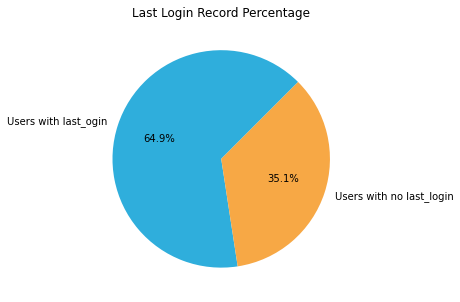

In [25]:

last_login_count = auth_user['last_login'].count()
total_count = len(auth_user)
last_login_pct = round(last_login_count / total_count * 100,2)

print('The user that has last_login record stands', last_login_pct, '%')

# Calculate percentages
last_login_pct = round(last_login_count / total_count * 100, 2)
no_last_login_pct = round(100 - last_login_pct, 2)

# Create pie chart
labels = ['Users with last_ogin', 'Users with no last_login']
sizes = [last_login_pct, no_last_login_pct]
colors = ['#2faedc', '#f7a845']
fig, ax = plt.subplots(figsize=(5, 5))

ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=45)
ax.set_title('Last Login Record Percentage')

plt.show()

Break down to see the quarterly login count from the first login data date in the dataset until the end of 2022.

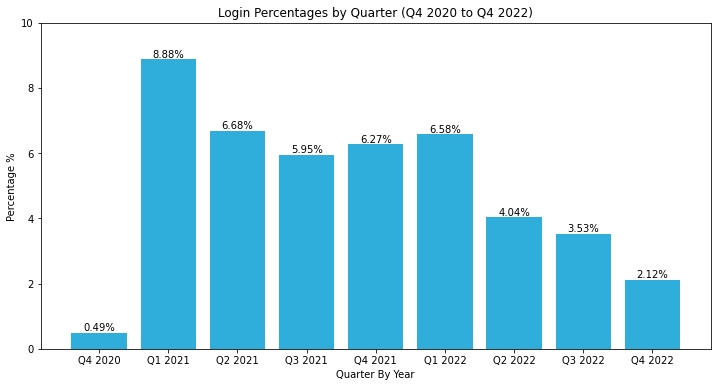

In [26]:
# convert 'last_login' column to datetime format
auth_user['last_login'] = pd.to_datetime(auth_user['last_login'], utc=True)

# create variables for start and end of each quarter from Q4 2020 to Q4 2022 as timezone-aware datetimes
start_dates = [pd.Timestamp('2020-10-01 00:00:00').tz_localize('UTC')] + \
              [pd.Timestamp(f'20{y}-{m:02d}-01 00:00:00').tz_localize('UTC') 
               for y in [21, 22] for m in [1, 4, 7, 10]]
end_dates = [pd.Timestamp(f'2020-12-31 23:59:59').tz_localize('UTC')] + \
            [pd.Timestamp(f'20{y}-{m:02d}-01 00:00:00').tz_localize('UTC') - pd.Timedelta('1s') 
             for y in [21, 22] for m in [3, 6, 9, 12]]

# calculate percentages of logins in each quarter
login_percentages = []
for i in range(len(start_dates)):
    quarter_count = ((auth_user['last_login'] >= start_dates[i]) & (auth_user['last_login'] <= end_dates[i])).sum()
    quarter_pct = round(quarter_count / total_count * 100, 2)
    login_percentages.append(quarter_pct)

#define quarters
quarters = ['Q4 2020', 'Q1 2021', 'Q2 2021', 'Q3 2021', 'Q4 2021', 'Q1 2022', 'Q2 2022', 'Q3 2022', 'Q4 2022']

    
#bar graph
# create figure object
fig = plt.figure(figsize=(12, 6))

# create bar chart with orange bars
plt.bar(quarters, login_percentages, color='#2faedc')

# add labels to the bars
for i, percentage in enumerate(login_percentages):
    plt.text(i, percentage, f"{percentage}%", ha='center', va='bottom')

# set axis labels and title
plt.xlabel('Quarter By Year')
plt.ylabel('Percentage %')
plt.ylim([0, 10])
plt.title('Login Percentages by Quarter (Q4 2020 to Q4 2022)')

plt.show()

## 2.2 Behind the Music: Investigating the Song Creators <a class="anchor" id="song-creators"></a>

In this section, we'll start narrowing it down, focusing specifically on the song creators on the platform, as they are the company's primary revenue stream. We start by examining the studio_song table to understand the artists, as this table contains information on song characteristics such as duration, show_collaborators, genre_id, etc. (see below).

### studio_song

In [27]:
studio_song.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29234 entries, 0 to 29233
Data columns (total 51 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      29234 non-null  int64  
 1   uuid                    29232 non-null  object 
 2   name                    29234 non-null  object 
 3   slug                    29234 non-null  object 
 4   duration                27484 non-null  float64
 5   featured                29234 non-null  bool   
 6   cover                   29234 non-null  object 
 7   banner_image            29234 non-null  object 
 8   colour_scheme           29234 non-null  int64  
 9   retraks_count           29234 non-null  int64  
 10  downloads_count         29234 non-null  int64  
 11  retrak                  29234 non-null  bool   
 12  stem                    29234 non-null  bool   
 13  description             17462 non-null  object 
 14  back_cover_description  0 non-null    

The data was cleaned for better processing.

1. Boolean values were converted to dummy variables 

2. Null values were replaced or removed.

3. Date was converted from string to datatime value.

In [28]:
# list down the columns with NaN
null_list= ['duration','description','back_cover_description','genre_id','reward_id','sub_genre_id',
            'original_creator_id','v2_id','v2_project_id']

# check null %
my_dict= {}
for c in null_list:
    null_percantage= check_null_percantage(studio_song,c)
    my_dict[c]= null_percantage

# sort the dict by values
sorted_d = sorted(my_dict.items(), key=lambda x: x[1], reverse=True)
sorted_d

# remove the variables with 100% null
# remove the id with no connection to other df 
df_studio_song = studio_song.drop(['back_cover_description','reward_id','v2_project_id','v2_id'], axis=1)

In [29]:
# list dowm col with empty list 
empty_list= ['cover', 'banner_image','description','back_cover_image','player_extra_image',
             'player_extra_image_2','player_extra_image_3','player_extra_image_4','player_image']

# see % of empty string 
my_dict= {}
for x in empty_list:
    empty_count = check_empty_string(df_studio_song,x)
    my_dict[x]=empty_count
    
my_dict= sorted(my_dict.items(), key= lambda x:x[1], reverse=True)

# remove the variables with 100% null
df_studio_song = df_studio_song.drop(['player_extra_image','player_extra_image_2',
                                      'player_extra_image_3','player_extra_image_4'], axis=1)

In [30]:
nan_columns = ['uuid', 'duration', 'description', 'genre_id', 'sub_genre_id', 'sub_sub_genre_id', 'original_creator_id']

# replace NaN with 'No data '
for col in nan_columns:
    df_studio_song[col].replace(np.nan, 'No Data', inplace=True)

In [31]:
# date_added is object, we want date format 

# updated_at
df_studio_song['updated_at'] = pd.to_datetime(df_studio_song['updated_at'], utc=True)
df_studio_song['updated_at'] = df_studio_song['updated_at'].dt.date

# created_at
df_studio_song['created_at'] = pd.to_datetime(df_studio_song['created_at'], utc=True)
df_studio_song['created_at'] = df_studio_song['created_at'].dt.date

# deleted_at
df_studio_song['deleted_at'] = pd.to_datetime(df_studio_song['deleted_at'], errors='coerce', utc=True)
df_studio_song['deleted_at'].replace(np.nan, 'No Data',inplace  = True) 

In [32]:
# convert boolean variables to integers 0 and 1
for col in df_studio_song:
    if df_studio_song[col].dtype == bool:
        df_studio_song[col] = df_studio_song[col].astype(int)

In [33]:
# convert boolean variables to integers 0 and 1
for col in auth_user:
    if auth_user[col].dtype == bool:
        auth_user[col] = auth_user[col].astype(int)

In [34]:
merged_df = pd.merge(df_studio_song, auth_user, how='left',left_on='user_id', right_on='id')
merged_df.head(3)
merged_df['is_staff'] = merged_df['is_staff'].replace({0.0: 0, 1.0: 1})
merged_df['is_active'] = merged_df['is_active'].replace({0.0: 0, 1.0: 1})

The entire dataset is plotted by a histogram instead of visualizing each variable individually. This allows us to understand the distribution of variables and the type of data we are dealing with. Another correlation matrix shows the relationship between different features.

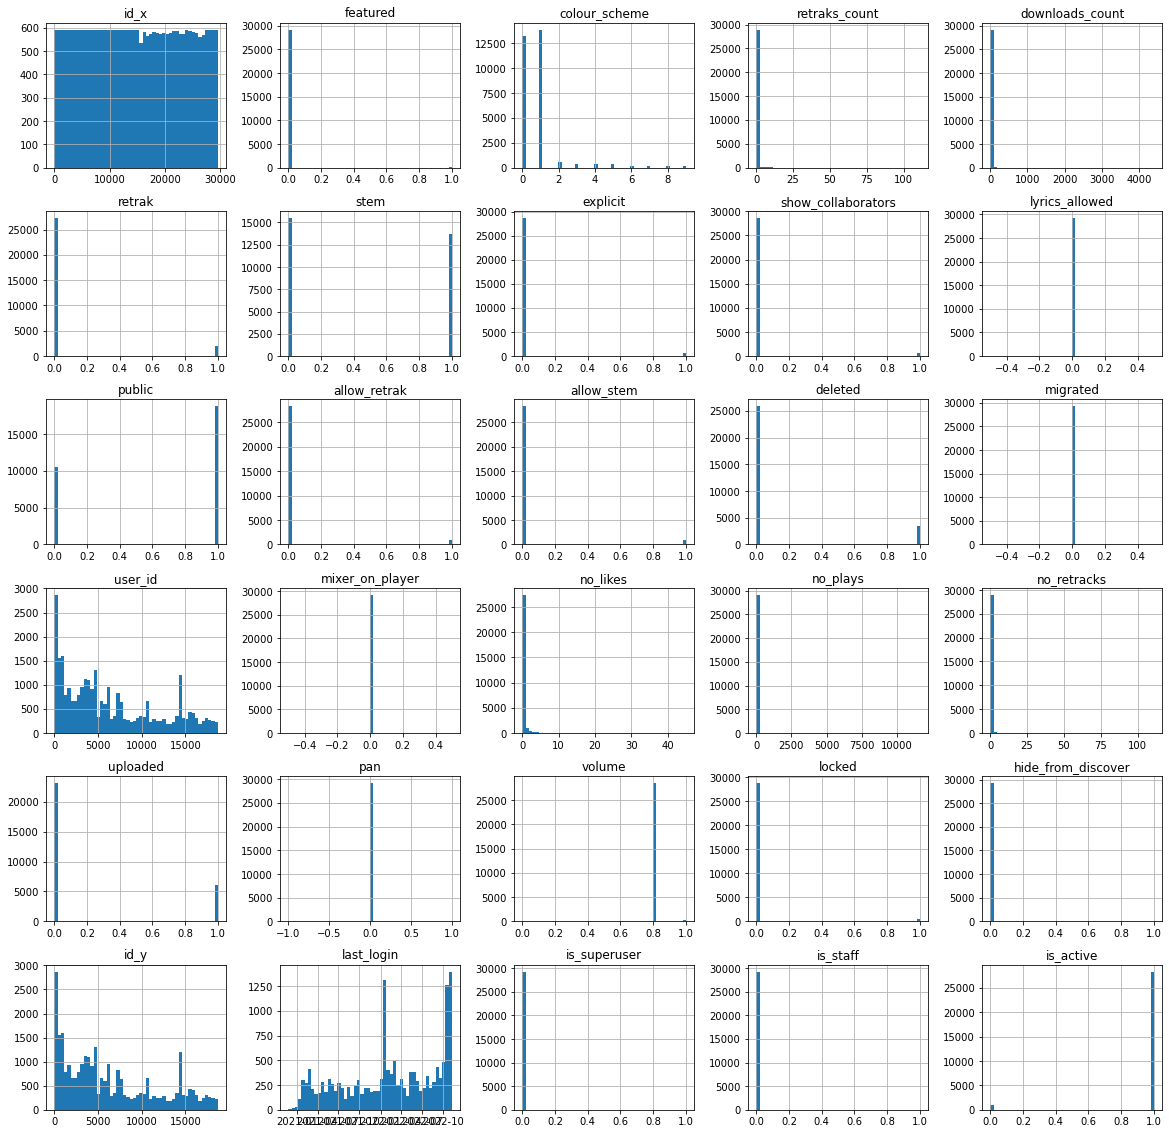

In [35]:
merged_df.hist(bins= 50, figsize=(20,20))
plt.show()

In [36]:
studio_song['migrated'].value_counts()

False    29234
Name: migrated, dtype: int64

In [37]:
# remove id and empty list and unwanted vars
corr_matrix= round(merged_df.corr(), 2)
corr_matrix= corr_matrix.drop(['lyrics_allowed', 'mixer_on_player','migrated','id_x','id_y','user_id' ], axis=0)
corr_matrix= corr_matrix.drop(['lyrics_allowed', 'mixer_on_player','migrated','id_x','id_y','user_id'], axis=1)

<AxesSubplot:>

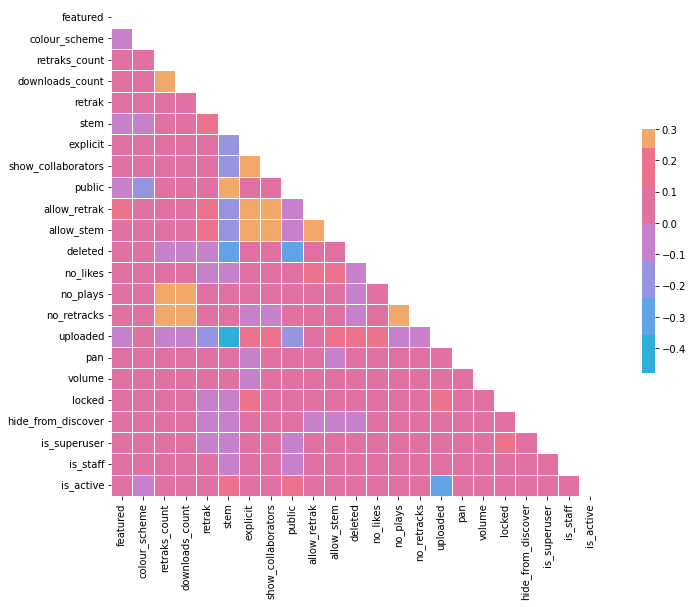

In [38]:
# generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 9))

# generate a custom diverging colormap
cmap = [ '#f19a68','#f2a76b','#ec728e', '#e271a3', '#c681ca', '#9994e2', '#62a3e7', '#2faedc']
# '#f3b471','#ef8c66','#ec7f65', '#ef7779', 

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap[::-1], vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Exploring the Relationship Between Features

Some findings are quite intuitive from the correlation matrix, for instance, it may not be a surprise to see the number of plays is highly correlated with the number of downloads. Nonetheless, the following two figures may bring us new insight. The first figure indicates that for non-public accounts, there are around 30% of deleted users. The second figure shows there is a slightly higher positive correlation between retraks_count and downloads_count, but the lack of definition of the variable limits our interpretation of its meaning.

In [39]:
# groups data by the "public", returns counts of unique values of "deleted"
df_sub = merged_df.groupby('public')['deleted'].value_counts(normalize=True).mul(100).reset_index(name='percentage')

# set the customised colour code
custom_palette = ['#f3b471','#ec7f65', '#e271a3', '#2faedc']

# plot the grouped bar chart 
fig = px.histogram(df_sub, x="public", y="percentage",
             color='deleted', barmode='group', title='The Relationship between public account and deleted account',
             height=500,color_discrete_sequence=custom_palette,
             hover_data={'percentage': ':.2f%'}, labels={'percentage': 'Percentage'})

fig.show()

In [40]:
# take log form to reduce the impact of outliers 
data_subx = np.log([x + 1 for x in merged_df['downloads_count']])
data_suby= np.log([x + 1 for x in merged_df['retraks_count']])


# create the scatterplot
fig = px.scatter(x=data_subx, y=data_suby)
fig.update_layout(title= "Relationship between downloads_count and retraks_count")
fig.update_xaxes(title="downloads_count")
fig.update_yaxes(title="retraks_count")

In [41]:
print("The correlation between retraks_count and downloads_count is", round(np.corrcoef(data_subx, data_suby)[0, 1], 2))

The correlation between retraks_count and downloads_count is 0.57


### Analyzing Yearly Creators Growth and Decline

A dramatic declining trend in creators can be observed. 

In [42]:
# date_joined
# add additional column for 'month' and 'year' 
# extract month and year from datetime series 
merged_df['joined']=1 
merged_df['year'] = pd.to_datetime(merged_df['date_joined'], errors='coerce',utc=True).dt.year.astype(str)

In [43]:
# filter the dataframe to only 'date_added' and 'type'
# group by month and return the count for each type (TV, Movies)
sub_df = merged_df.groupby('year')['joined'].sum().reset_index(name='counts')

cmap = ["#2FAEDC"]
color_sequence = ['#1f77b4', '#ff7f0e', '#2ca02c']

fig = px.bar(sub_df, x='year', y='counts', title='Creators joined by Year',color_discrete_sequence=cmap)

# let year interval=1 
# fig.update_layout(xaxis=dict(tickmode='linear', dtick=1))
fig.show()

### Exploring Song Genres: A Comprehensive Study of Song Categorisation

Here we see that the most uploaded and most listened to songs are concentrated in hip hop, rap and rock.

In [44]:
df_discover_genres= discover_genres.drop(['image','banner_image','parent_id',
                                             'search_count','image_inactive','image_active'], axis=1)

df_studio_song= studio_song.drop(['reward_id','sub_genre_id','sub_sub_genre_id','back_cover_image',
                     'player_extra_image','player_extra_image_2','player_extra_image_3','player_extra_image_4',
                     'player_image','v2_project_id','original_creator_id','cover','banner_image','uuid'], axis=1)

In [48]:
df_studio_song_2 = studio_song
df_studio_song_2 = df_studio_song_2.drop(df_studio_song_2.columns[[1,3,6,7,14,31,32,33,34,35,36]],axis = 1)

df_discover_genres_2 = discover_genres[['id', 'tag', 'tag_type']]
df_discover_genres_2 = df_discover_genres_2.rename(columns={'id': 'genre_id'})

# merging genres data to df_studio_song
df_studio_song_2 = df_studio_song_2.merge(df_discover_genres_2, on='genre_id', how='left')

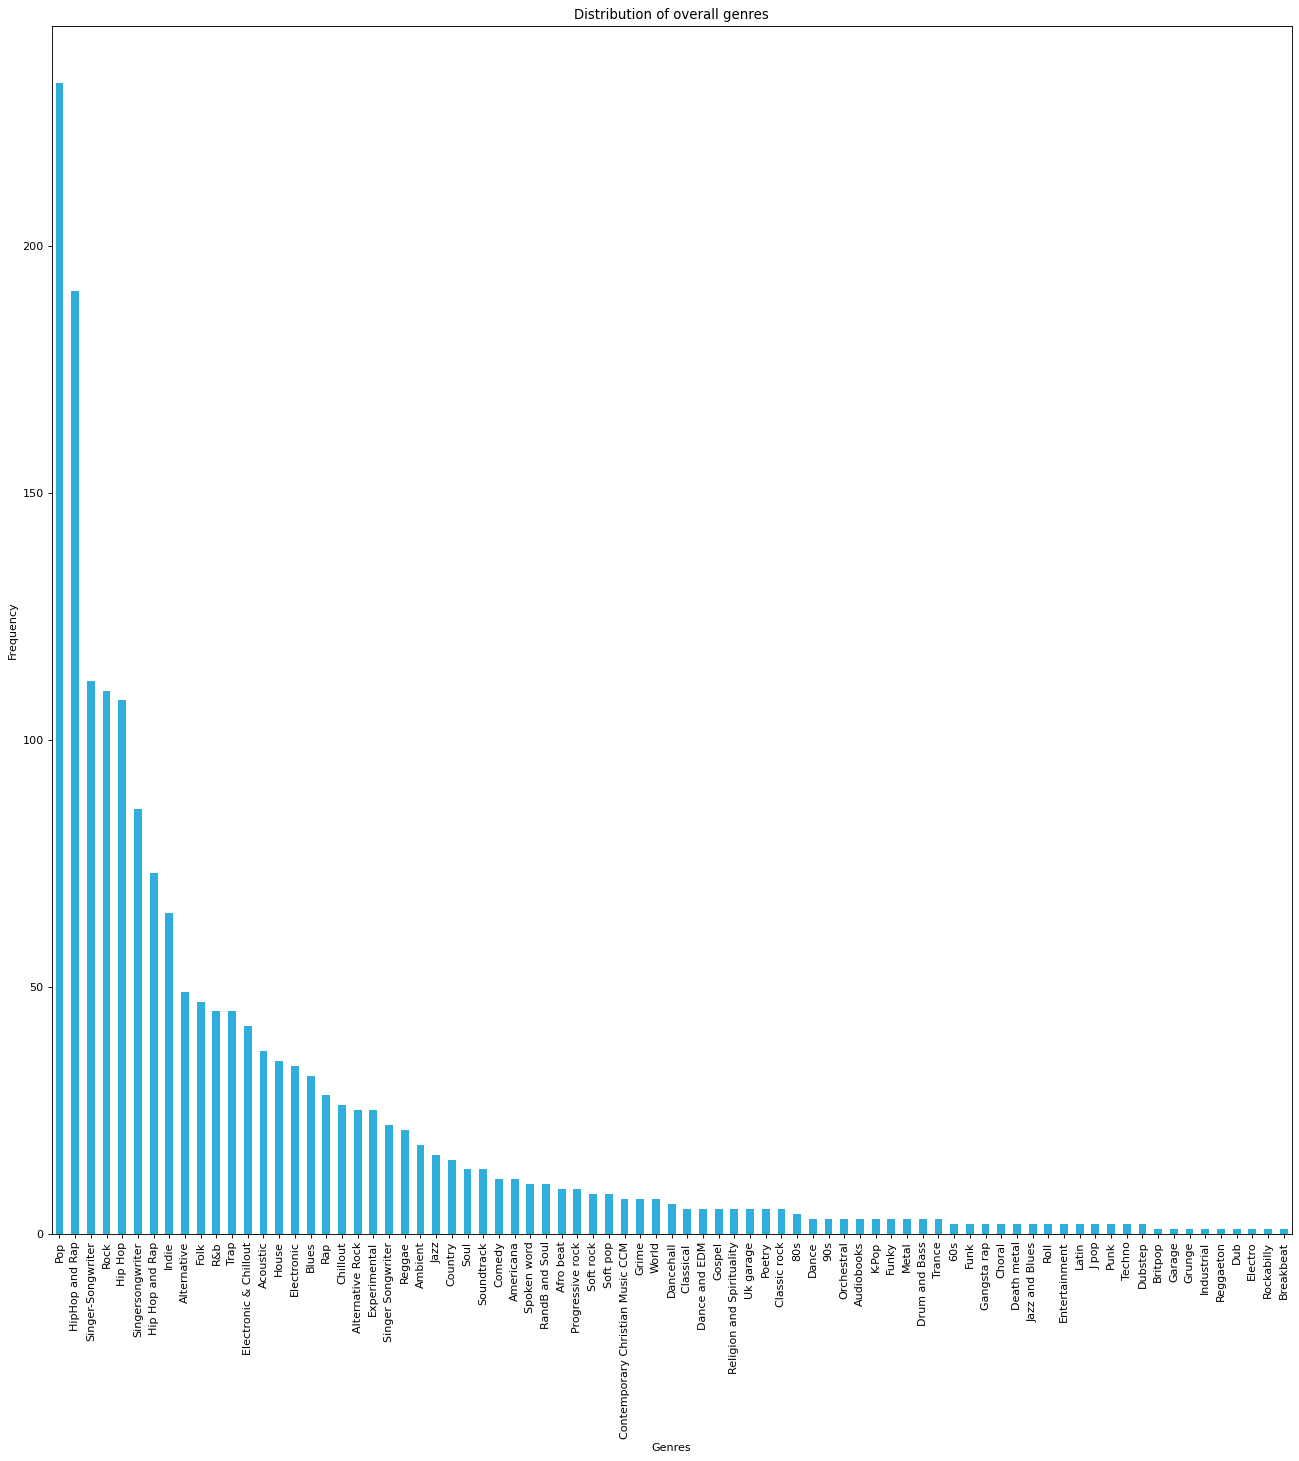

In [50]:
# check distibution of genres
figure(figsize=(20, 20), dpi=80)
df_studio_song_2['tag'].value_counts().plot(kind='bar', color='#2faedc')

plt.title('Distribution of overall genres')
plt.xlabel('Genres')
plt.ylabel('Frequency')

plt.show()

In [51]:
merged_df = pd.merge(df_studio_song, df_discover_genres, how='left',left_on='genre_id', right_on='id')
merged_df.dropna(subset=['tag'],inplace=True)
merged_df['tag'] = merged_df['tag'].replace('Hip Hop and Rap', 'HipHop and Rap')
sub_df= merged_df.groupby('tag').size().reset_index(name='counts').sort_values(by='counts', ascending=False)[:5]
sub_df

tag  counts
41     HipHop and Rap     264
53                Pop     233
66  Singer-Songwriter     112
62               Rock     110
40            Hip Hop     108

In [52]:
# top 10 most common genres
fig = px.bar(sub_df, x='tag', y='counts', title='Top 5 most common genres uploaded',color_discrete_sequence=['#2FAEDC'])
fig.update_traces(text=sub_df['counts'],textposition='outside')

In [53]:
# top 10 most popular genres, total 
sub_df= merged_df.groupby('tag')['no_plays'].sum().reset_index().sort_values(by='no_plays', ascending=False)[:10]
sub_df

tag  no_plays
3            Acoustic     13307
53                Pop      7833
41     HipHop and Rap      5611
62               Rock      4436
67   Singersongwriter      3268
66  Singer-Songwriter      1902
5         Alternative      1678
32               Folk      1531
28         Electronic      1024
43              Indie       976

In [54]:
# top 10 most popular genres, single song
top_plays = sub_df.nlargest(5, 'no_plays')

# top 10 most popular genres
fig = px.bar(top_plays, x='tag', y='no_plays', title='Top 5 most popular genres by no. of play',color_discrete_sequence=['#2FAEDC'])
fig.update_traces(text=top_plays['no_plays'],textposition='outside')

### Exploring Artist Performance

To understand some of the features that influence artist performance base on liked tracks

In [55]:
df_userprofile_2 = users_userprofile

# remove useless columns
df_userprofile_2 = df_userprofile_2.drop(df_userprofile_2.columns[[4,5,6,7,8,15,16,17,18,20,23,24,26,27,28,29,30,32,
                                                             33,34,35,36,37,38,39,41,43,44,45,46,47,48,49,50,
                                                             53,54,56,58,59,60,61,62,64]],axis = 1)

df_creator_2 = df_userprofile_2[df_userprofile_2['user_type'] == 'creator']


In [56]:
# check statistic details for the likes distribution 
df_creator_2['no_likes'].describe()

# an outlier was identified with 176 plays, hence it was removed in the histogram below

count    6816.000000
mean        5.938527
std         8.942018
min         0.000000
25%         0.000000
50%         0.000000
75%        15.000000
max       176.000000
Name: no_likes, dtype: float64

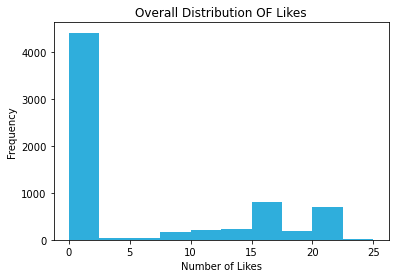

In [57]:
# Create a histogram of the number of likes
plt.hist(df_creator_2['no_likes'], range=[0,25], bins=10, color='#2faedc')

plt.title('Overall Distribution OF Likes')
plt.xlabel('Number of Likes')
plt.ylabel('Frequency')
plt.show()

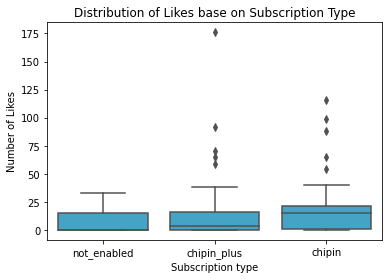

In [58]:
# Create a boxplot of the number of likes by subscription type
sns.boxplot(x='chipin_account_type', y='no_likes', data=df_creator_2, color='#2faedc')

plt.title('Distribution of Likes base on Subscription Type')
plt.xlabel('Subscription type')
plt.ylabel('Number of Likes')
plt.show()

### Examining the Geographic Distribution of Artists

The location of the creators was also analyzed, and we found that the majority of creators were based in the US and UK, followed by European countries, Australia, and Canada.

In [59]:
df_users_registrationcountry= users_registrationcountry[['id','name']]
df_users_registrationcountry.head(5)

df_users_userlocation= users_userlocation[['country_id','user_id']]

# merge users_registrationcountry and users_userlocation 

merged1_df = pd.merge(df_users_userlocation, df_users_registrationcountry, how='left',
                     left_on='country_id', right_on='id')

merged1_df[:5]

df_auth_user= auth_user[['id']]

merged2_df = pd.merge(merged1_df, df_auth_user, how='left',left_on='user_id', right_on='id')

In [60]:
merged2_df.drop_duplicates(subset='id_y', inplace=True)

query = "SELECT * FROM studio_song"
df_studio_song= pd.read_sql_query(query, conn)
df_studio_song.head(2)

merged3_df = pd.merge(df_studio_song, merged2_df, how='left',left_on='user_id', right_on='id_y')
merged3_df.dropna(subset=['name_y'], inplace=True)
sub_df= merged3_df.groupby('name_y').size().reset_index(name='counts').sort_values(by='counts',ascending=False)[:10]

# rename the "name_y" column to "country"
sub_df = sub_df.rename(columns={'name_y': 'country'})

sub_df

country  counts
54   United States    5061
53  United Kingdom    3639
32     Netherlands     937
9           Canada     585
2        Australia     300
45    South Africa     197
46           Spain     191
22           India     142
15          France      63
26           Italy      53

In [61]:
# top 10 most creator countries
fig = px.bar(sub_df, x='country', y='counts', title='Top 10 most creator countries',color_discrete_sequence=['#2FAEDC'])
fig.update_traces(text=sub_df['counts'],textposition='outside')

In [62]:
sub_df= merged3_df.groupby('name_y').size().reset_index(name='counts').sort_values(by='counts',ascending=False)

geolocator = Nominatim(user_agent="myApplication")

# define a function to apply the geolocator to each row
def get_coordinates(row):
    location = geolocator.geocode(row['name_y'])
    if location is None:
        return None, None
    return location.latitude, location.longitude

# apply the function to each row of the dataframe
sub_df[['latitude', 'longitude']] = sub_df.apply(get_coordinates, axis=1, result_type='expand')

# rename the "name_y" column to "country"
sub_df = sub_df.rename(columns={'name_y': 'country'})

# print the resulting dataframe
sub_df.head(5)

country  counts   latitude   longitude
54   United States    5061  39.783730 -100.445882
53  United Kingdom    3639  54.702354   -3.276575
32     Netherlands     937  52.243498    5.634323
9           Canada     585  61.066692 -107.991707
2        Australia     300 -24.776109  134.755000

In [63]:
# define the color scale
color_scale = [
    (0, '#4292c6'),  # red
    (1, '#d6604d')  # blue
]

# create the scattermapbox visualization
fig = px.scatter_mapbox(sub_df[:20], lat="latitude", lon="longitude", size="counts",
                        color="counts",color_continuous_scale=color_scale,
                        zoom=1, mapbox_style="carto-positron")

fig.update_layout(title='Trackd market by size')

### Popularity Analysis


Visualise the correlation of top performing tracks by its plays, likes and downloads

In [64]:
# sort the data by the number of downloads, plays, or likes:
download_sorted = df_studio_song_2.sort_values(by='downloads_count', ascending=False)
play_sorted = df_studio_song_2.sort_values(by='no_plays', ascending=False)
like_sorted = df_studio_song_2.sort_values(by='no_likes', ascending=False)

In [65]:
# filter the data by the number of downloads, plays, or likes:
download_top_10 = download_sorted.head(10)
play_top_10 = play_sorted.head(10)
like_top_10 = like_sorted.head(10)

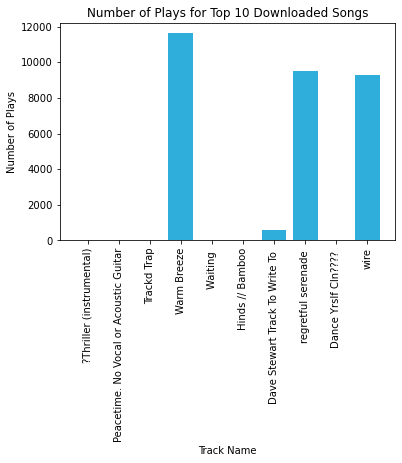

In [66]:
# plotting a chart to visualise top downloaded songs by its plays
plt.bar(download_top_10['name'], download_top_10['no_plays'], color='#2faedc')

plt.title('Number of Plays for Top 10 Downloaded Songs')
plt.xlabel('Track Name')
plt.ylabel('Number of Plays')

plt.xticks(rotation = 90)

plt.show()

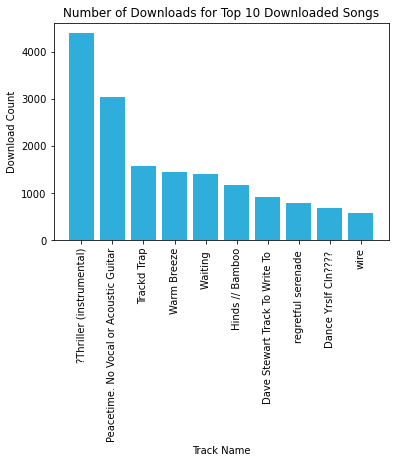

In [67]:
# plotting a chart to visualise top downloaded songs by its counts
plt.bar(download_top_10['name'], download_top_10['downloads_count'], color='#2faedc')

plt.title('Number of Downloads for Top 10 Downloaded Songs')
plt.xlabel('Track Name')
plt.ylabel('Download Count')

plt.xticks(rotation = 90)

plt.show()

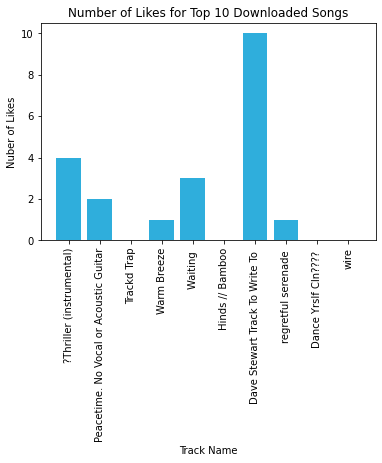

In [68]:
# plotting a chart to visualise top downloaded songs by its likes
plt.bar(download_top_10['name'], download_top_10['no_likes'], color='#2faedc')

plt.title('Number of Likes for Top 10 Downloaded Songs')
plt.xlabel('Track Name')
plt.ylabel('Nuber of Likes')

plt.xticks(rotation = 90)

plt.show()

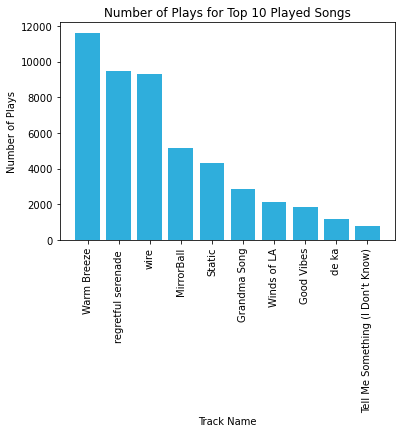

In [69]:
# plotting a chart to visualise top played songs by its play distribtuion
plt.bar(play_top_10['name'], play_top_10['no_plays'], color='#2faedc')

plt.title('Number of Plays for Top 10 Played Songs')
plt.xlabel('Track Name')
plt.ylabel('Number of Plays')

plt.xticks(rotation = 90)

plt.show()

# 3. Segmentation by PCA and Unsupervised-learning methods <a class="anchor" id="segmentation"></a>

## 3.1 Data Wrangling <a class="anchor" id="data-wrangling"></a>

### Merging mutiple tables 

This section aims to conduct creator-side segmentation in line with our previous findings. To achieve this, it would be sensible to filter out any less relevant tables in the data repository.

We treated 'studio_song' as our primary dataset since it contains information such as all the songs listed on the platform, song duration, number of likes/listens, and collaboration permissions etc. (see the below output). To create a comprehensive view of the data, we have merged all datasets linked to this table into one large dataframe.

It's worth noting that the 'user_profile' data, which includes demographic information about users, is not directly linked to 'studio_song'. As a result, special handling is required to link this information back to the song list. One possible approach is to merge the 'user_profile' data with 'auth_user' data, and then link the combined data back to 'studio_song'.

In [70]:
query = "SELECT * FROM studio_song"
df_main  = pd.read_sql_query(query, conn)
df_main.head(3)

id                                  uuid          name          slug  \
0  10  131e3e71-05bd-45b1-8a5b-8e6e72ccf874   Turn Around   turn-around   
1  29  ba729883-ff53-4c98-a1cd-b548aaf837e7   Mini-Collab   mini-collab   
2  37  0a7b22ca-2f92-48dc-876c-2506e0c07d87  Edmonton jam  edmonton-jam   

   duration  featured cover banner_image  colour_scheme  retraks_count  ...  \
0     165.0     False                                 0              0  ...   
1      47.0     False                                 0              0  ...   
2      79.0     False                                 0              0  ...   

   original_creator_id     state   v2_id v2_project_id uploaded  source  pan  \
0                  NaN  complete  1095.0          None    False     ios  0.0   
1                  NaN  complete   424.0          None    False     ios  0.0   
2                  NaN  complete  2232.0          None    False     ios  0.0   

   volume  locked  hide_from_discover  
0     0.8   False               False  
1     0.8   False               False  
2     0.8   False               False  

[3 rows x 51 columns]

### Handling 'user_profile'

In [71]:
# import 'users_userprofile' and 'auth_user'

# 'users_userprofile'
query = "SELECT * FROM users_userprofile"
df_users_userprofile  = pd.read_sql_query(query, conn)

# only select the relevant columns
df_users_userprofile = df_users_userprofile[['user_id', 'gender', 'date_of_birth', 'chipin_account_type']]
df_users_userprofile['date_of_birth'] = pd.to_datetime(df_users_userprofile['date_of_birth'], errors='coerce')
df_users_userprofile['date_of_birth'] = df_users_userprofile['date_of_birth'].dt.year
df_users_userprofile.head(3)

# 'auth_user'
query = "SELECT * FROM auth_user"
df_auth_user = pd.read_sql_query(query, conn)
df_auth_user.head(3)

id                                           password  \
0     6  bcrypt_sha256$$2b$12$tqU2Op6U0k/gV.xg0uMl8.Noy...   
1  8648          !3QcFDJ3mnwNmoNyIUzafxiSI41iAS5wAk305e1nf   
2  8515          !8vh3LNN2u9HiwFxGvP7ZTygvcO2o9c49NhXl4Cxo   

                         last_login  is_superuser       username first_name  \
0                              None         False  rachelayjay89              
1  2022-01-28 05:25:07.979401+00:00         False         ownmus       Alex   
2  2021-02-21 16:34:08.663876+00:00         False     TBDpodcast      Blake   

  last_name  is_staff  is_active                       date_joined  
0               False       True  2020-11-18 15:02:57.928304+00:00  
1      Vish     False       True  2021-02-24 13:04:30.846037+00:00  
2    Juarez     False       True  2021-02-21 16:30:39.068049+00:00

In [72]:
# combine 'users_userprofile' with 'auth_user'
df_auth_user = pd.merge(df_auth_user, df_users_userprofile, how='left', left_on='id', right_on='user_id')
df_auth_user= df_auth_user.drop('user_id', axis=1)
df_auth_user.head(3)

id                                           password  \
0     6  bcrypt_sha256$$2b$12$tqU2Op6U0k/gV.xg0uMl8.Noy...   
1  8648          !3QcFDJ3mnwNmoNyIUzafxiSI41iAS5wAk305e1nf   
2  8515          !8vh3LNN2u9HiwFxGvP7ZTygvcO2o9c49NhXl4Cxo   

                         last_login  is_superuser       username first_name  \
0                              None         False  rachelayjay89              
1  2022-01-28 05:25:07.979401+00:00         False         ownmus       Alex   
2  2021-02-21 16:34:08.663876+00:00         False     TBDpodcast      Blake   

  last_name  is_staff  is_active                       date_joined  gender  \
0               False       True  2020-11-18 15:02:57.928304+00:00  female   
1      Vish     False       True  2021-02-24 13:04:30.846037+00:00    male   
2    Juarez     False       True  2021-02-21 16:30:39.068049+00:00    male   

   date_of_birth chipin_account_type  
0            NaN         not_enabled  
1         1987.0         not_enabled  
2         1992.0         not_enabled

### Merging tables into 1 large dataframe

Here, we list down all the tables that are connected to studio_song table through the 'song_id' column while filtering out any table with all the song_id values missing. We want to exclude these tables from the list since they cannot be merged without proper identification. Additionally, the observations with no song_id are removed.

In [73]:
list_tables= ['chipin_transaction','fingerprint_fingerprintreport','profanity_imageprofanityreport',
         'studio_songtrack','notifications_notifications' ,'studio_songcomment','history_playhistory',
         'studio_songprofilesectionorder','marketing_pushnotification','backoffice_completedaudit',
         'studio_lyric','studio_songbounce','marketing_deeplink' ,'marketing_pushnotificationsequenced',
         'studio_songlikes','studio_featuredusersong','studio_songcollaboration','backoffice_sectionasset',
         'studio_songretrak','playlists_playlistsong','studio_recordsetting','studio_songcoverimage',
         'studio_songmixersettings','studio_songprofileview','studio_songreport','backoffice_discoversection',
         'backoffice_tridentrecord','studio_song_tags']

# create an empty list to store dfs with all NaN song_id values
empty_df_names = []

# loop through each df in the list
for df_x in list_tables:
    # read the df from the database
    query = f"SELECT * FROM {df_x}"
    df = pd.read_sql_query(query, conn)
    
    # Check if all values in the "song_id" column are NaN
    if df['song_id'].isnull().all():
        # Add the dataframe name to the list if all values are NaN
        empty_df_names.append(df_x)

# see the dfs with all NaN song_id values 
print('The tables with compele empty song_id is:',empty_df_names)

The tables with compele empty song_id is: ['chipin_transaction', 'notifications_notifications', 'marketing_deeplink', 'marketing_pushnotificationsequenced', 'studio_songcoverimage', 'backoffice_tridentrecord']


In [74]:
# tables after removing the dfs with no song_id at all 
tables= ['fingerprint_fingerprintreport','profanity_imageprofanityreport','studio_songtrack',
         'studio_songcomment','history_playhistory','studio_songprofilesectionorder',
         'marketing_pushnotification','backoffice_completedaudit','studio_lyric','studio_songbounce',
         'studio_songlikes','studio_featuredusersong','studio_songcollaboration','backoffice_sectionasset',
         'studio_songretrak','playlists_playlistsong','studio_recordsetting','studio_songmixersettings',
         'studio_songprofileview','studio_songreport','backoffice_discoversection','studio_song_tags']

# create an empty dict to store the updated dfs
updated_dfs = {}

# loop through each dataframe in the list
# detect df with null song_id
# drop observation that has song_id= null
for df_name in tables:
    # read the dataframe from the database
    query = f"SELECT * FROM {df_name}"
    df = pd.read_sql_query(query, conn)
    # drop rows with null values in 'song_id' column
    df = df.dropna(subset=['song_id']) 
    # drop col with all Nan values 
    df.dropna(axis=1, how='all', inplace=True)      
    # store the updated dataframe in the dictionary
    updated_dfs[df_name] = df
    
# check whether null song_id is removed 
check_list= []
for df in updated_dfs:
    sum_null= updated_dfs[df]['song_id'].isnull().sum()
    check_list.append(sum_null)

print('The number of NaN in song_id from each table is:', check_list)

The number of NaN in song_id from each table is: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Finally, create another for loop that automatically merges the dataframes for us using the list after removing the identified tables.

In [75]:
# initialise the first merge 
# let id becomes id_x
merged_init = pd.merge(df_main, updated_dfs['fingerprint_fingerprintreport'], how='left', left_on='id', right_on='song_id')

# loop through each dataframe in updated_dfs and merge it with merged_df
# the new df now has 231 variables 
merged_df = merged_init
for i, (table, df) in enumerate(updated_dfs.items()):
    if i > 0:
        merged_df = pd.merge(merged_df, df, how='left', left_on='id_x', right_on='song_id', suffixes=('_left', '_right'))
        merged_df = merged_df.drop_duplicates(subset=['id_x'], keep='last')
        
merged_df.head(3)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29234 entries, 0 to 30206
Columns: 231 entries, id_x to genres_id
dtypes: bool(22), float64(87), int64(16), object(106)
memory usage: 47.5+ MB


Since the following 3 tables link with studio_song through other identifiers rather than song_id and as a result we will deal with them separately. After we merged all the tables we want, we drop all the identifiers as they are not economically meaningful variables.

In [76]:
# discover_genres
query = "SELECT * FROM discover_genres"
df_discover_genres = pd.read_sql_query(query, conn)
merged_df = pd.merge(merged_df, df_discover_genres, how='left', left_on='genres_id', right_on='id')

# studio_reward
query = "SELECT * FROM studio_reward"
df_studio_reward = pd.read_sql_query(query, conn)
df_studio_reward['id'] = df_studio_reward['id'].astype(str)
merged_df = pd.merge(merged_df, df_studio_reward, how='left', left_on='reward_id', right_on='id')

# df_auth_user
merged_df = pd.merge(merged_df, df_auth_user, how='left', left_on='user_id', right_on='id')

# check the df again 
merged_df.head(1)
print("The data info 1.")
merged_df.info()

# drop all the columns with "id" included in the name 
# regex parameter catch the column names containing "id"
id_cols = merged_df.filter(regex='id').columns

# check if we catch the right cols
# print(id_cols) #all contains ids
# reduce to 177 variables
merged_df = merged_df.drop(columns=id_cols)
print("The data info 2.")
merged_df.info()

# check for duplicate cols
duplicated_cols = merged_df.columns[merged_df.columns.duplicated(keep=False)]
# print(duplicated_cols) # duplicate columns are timestamp 

# drop the duplicate columns
# we don't want time stamp for our segmentation as segmentation will based creator characteristics 
# 141 variables 
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]
print("The data info 3.")
merged_df.info()

# check for duplicate cols 
duplicate_cols = merged_df.columns[merged_df.columns.duplicated()]
if len(duplicate_cols) == 0:
    print("No duplicate columns found.")
else:
    print("Duplicate columns found: ", duplicate_cols)

The data info 1.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29234 entries, 0 to 29233
Columns: 260 entries, id_x to chipin_account_type
dtypes: bool(22), float64(93), int64(16), object(129)
memory usage: 53.9+ MB
The data info 2.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29234 entries, 0 to 29233
Columns: 174 entries, name_x to chipin_account_type
dtypes: bool(21), float64(19), int64(10), object(124)
memory usage: 34.9+ MB
The data info 3.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29234 entries, 0 to 29233
Columns: 138 entries, name_x to chipin_account_type
dtypes: bool(21), float64(18), int64(9), object(90)
memory usage: 26.9+ MB
No duplicate columns found.


### Cleaning the Data

Since PCA is only capable of processing numerical values, some data manipulations are required in advance, that is to ensure that we feed the PCA module only with effective inputs.

In [77]:
merged_df.head(3)

name_x          slug  duration_left  featured cover banner_image_x  \
0   Turn Around   turn-around          165.0     False                        
1   Mini-Collab   mini-collab           47.0     False                        
2  Edmonton jam  edmonton-jam           79.0     False                        

   colour_scheme_left  retraks_count  downloads_count  retrak  ...  \
0                   0              0                0   False  ...   
1                   0              0                0   False  ...   
2                   0              0                0   False  ...   

   is_superuser username first_name  last_name  is_staff  is_active  \
0           NaN      NaN        NaN        NaN       NaN        NaN   
1           NaN      NaN        NaN        NaN       NaN        NaN   
2           NaN      NaN        NaN        NaN       NaN        NaN   

   date_joined  gender  date_of_birth  chipin_account_type  
0          NaN     NaN            NaN                  NaN  
1          NaN     NaN            NaN                  NaN  
2          NaN     NaN            NaN                  NaN  

[3 rows x 138 columns]

### Handling boolean columns

In [78]:
# select the cols with boolean type
boolean_columns = merged_df.select_dtypes(include=['bool']).columns
print(boolean_columns)

# convert all boolean columns to binary values for later process 
boolean_columns = merged_df.select_dtypes(include=['bool']).columns
merged_df.loc[:, boolean_columns] = merged_df.loc[:, boolean_columns].astype(int)
merged_df.head(3)

Index(['featured', 'retrak', 'stem', 'explicit_left', 'show_collaborators',
       'lyrics_allowed', 'public', 'allow_retrak', 'allow_stem',
       'deleted_left', 'migrated', 'mixer_on_player', 'uploaded', 'locked',
       'monitor', 'line_input', 'click', 'click_recording', 'count',
       'wave_forms', 'allow_collaboration'],
      dtype='object')


name_x          slug  duration_left  featured cover banner_image_x  \
0   Turn Around   turn-around          165.0         0                        
1   Mini-Collab   mini-collab           47.0         0                        
2  Edmonton jam  edmonton-jam           79.0         0                        

   colour_scheme_left  retraks_count  downloads_count  retrak  ...  \
0                   0              0                0       0  ...   
1                   0              0                0       0  ...   
2                   0              0                0       0  ...   

   is_superuser username first_name  last_name  is_staff  is_active  \
0           NaN      NaN        NaN        NaN       NaN        NaN   
1           NaN      NaN        NaN        NaN       NaN        NaN   
2           NaN      NaN        NaN        NaN       NaN        NaN   

   date_joined  gender  date_of_birth  chipin_account_type  
0          NaN     NaN            NaN                  NaN  
1          NaN     NaN            NaN                  NaN  
2          NaN     NaN            NaN                  NaN  

[3 rows x 138 columns]

### Handling  categorical values

During the data exploration stage in the previous section, we acknowledge that song genres can be an important feature for Trackd as they related to platform trends and the business's unique selling point (USP); thus, we adopt the Original Encoding method to convert string into numerical values.

In [79]:
# replace NaN values with 'Unknown'
merged_df['tag'].fillna(value='Unknown', inplace=True)

# create an encoder, handle_unknown set to 'ignore'
encoder = OrdinalEncoder(handle_unknown='error')

# fit and transform the encoder on df
merged_df['cat_genre'] = encoder.fit_transform(merged_df[['tag']])

# see the categories generated by the encoder
print(encoder.categories_)

# change unknown for KNN method in later section
merged_df['cat_genre'] = merged_df['cat_genre'].replace(42, np.nan)

[array(['Acoustic', 'African', 'Alternative', 'Alternative Rock',
       'Ambient', 'Blues', 'Chant', 'Chillout', 'Classic', 'Classic rock',
       'Classical', 'Contemporary Christian Music CCM', 'Country',
       'Electro', 'Electronic', 'Electronic & Chillout', 'Experimental',
       'Folk', 'Funk', 'GENRE', 'Hip Hop', 'Hip Hop and Rap',
       'HipHop and Rap', 'Indie', 'Indoe', 'Jazz', 'Liturgical', 'Poetry',
       'Pop', 'Progressive rock', 'Punk', 'RandB and Soul', 'Rap',
       'Rhythm', 'Rock', 'Singer Songwriter', 'Singersongwriter',
       'Soft rock', 'Soul', 'Soundtrack', 'Spoken word', 'Trap',
       'Unknown'], dtype=object)]


### Handling missing values 

To deal with a large number of missing values, it may not be appropriate to fill the NaN simply with the mean or median, as this could introduce significant bias and lead to misinterpretation. Instead, K-Nearest Neighbors (KNN) imputation is applied because this method takes the relationship between different features into consideration and estimates the missing values accordingly.

In [80]:
# running this secion may take a while (~1min)
# select only numerical cols 
numeric_cols = merged_df.select_dtypes(include=np.number).columns.tolist()
merged_df = merged_df[numeric_cols]

# drop the cols with all NaN
merged_df.dropna(axis=1, how='all', inplace=True)
merged_df.head(3)

# create a StandardScaler object
scaler = StandardScaler()

# Standardize the data
df_std = scaler.fit_transform(merged_df)

# create an instance of the KNN imputer
knn = KNNImputer(n_neighbors=5)

# fit and transform the imputer on your DataFrame
df_imputed = pd.DataFrame(knn.fit_transform(merged_df), columns=merged_df.columns)

In [81]:
# check the imputed df 
df_imputed.head(3)

duration_left  featured  colour_scheme_left  retraks_count  \
0          165.0       0.0                 0.0            0.0   
1           47.0       0.0                 0.0            0.0   
2           79.0       0.0                 0.0            0.0   

   downloads_count  retrak  stem  explicit_left  show_collaborators  \
0              0.0     0.0   0.0            0.0                 0.0   
1              0.0     0.0   0.0            0.0                 0.0   
2              0.0     0.0   0.0            0.0                 0.0   

   lyrics_allowed  ...   tap  count  count_tempo  wave_forms  \
0             0.0  ...  20.0    0.0          0.0         1.0   
1             0.0  ...  20.0    0.0          0.0         1.0   
2             0.0  ...  20.0    0.0          0.0         1.0   

   allow_collaboration  colour_scheme_right  fade_right  order_right  \
0                  1.0                  1.0        50.0         61.2   
1                  1.0                  1.0        50.0         62.4   
2                  1.0                  1.0        50.0         62.4   

   search_count  cat_genre  
0           0.0       11.6  
1           0.0       25.4  
2           0.0       27.4  

[3 rows x 47 columns]

## 3.2 Dimensionality Reduction using Principal Component Analysis (PCA) <a class="anchor" id="pca"></a>

Now, the dataset is cleaned and ready to be fed into the PCA analysis. This method is applied before the clustering as it helps us to reduce the dimension (features) and therefore reinforce the clustering process. We set the n_components=0.95 instead of setting the number of dimensions directly because we want to find out the number of dimensions that allow us to preserve 95% of the data variance (data information). Besides, the explained variance by dimension is plotted to visualise the elbow.

The number of dimensions that preserved 95% variance in the data is: 28


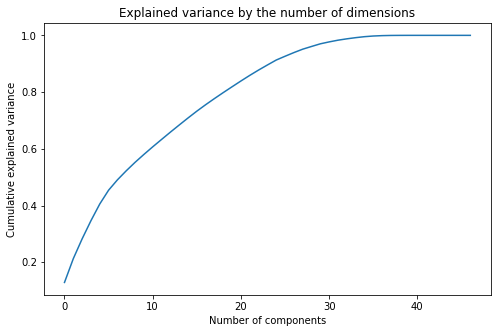

In [82]:
# create a PCA object 
# we want to preserve 95% of variance in the data 
pca = PCA(n_components=0.95)

# create standardscaler 
scaler = StandardScaler()

# fit the scaler to the data and transform it
scaled_data = scaler.fit_transform(df_imputed)

# fit the PCA object to the scaled data
pca.fit(scaled_data)

# transform the data into the new PCA space
pca_data = pca.transform(scaled_data)

# see the number of dimenstion that preserved the highest variance
print("The number of dimensions that preserved 95% variance in the data is:", pca.n_components_)

# plot cumulative sum of explained variance by dimension 
pca = PCA().fit(scaled_data)
figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title("Explained variance by the number of dimensions")
plt.show()

## 3.3 Clustering by K-mean and DBSCAN <a class="anchor" id="cluster"></a>

As the data on hand is unlabeled, clustering is one of the most common unsupervised learning methods that elaborate our data exploration even further. Through this method, we are able to group observations with similar characteristics and potentially perform market segmentation to enhance customer targeting for Trackd. In this section, 2 different clustering algorithms are performed, namely K-mean and DBSCAN. The purpose is to compare their effectiveness and evaluate the most suitable algorithm that outperforms the other correspondingly.

### K-mean clustering

First, k-mean clustering is applied to the pca dataset and the number of clusters is selected using the silhouette score. From the figure below, we observed that cluster=2 possesses the highest score compared to others, hence suggesting that k=2 is the optimal cluster that should be set in our k-mean clustering.

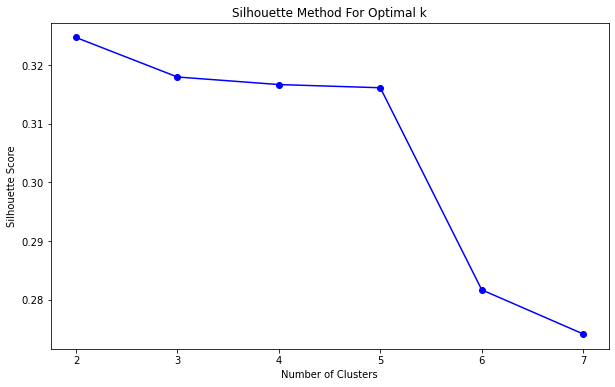

The optimal number of clusters is: 2


In [83]:
# create a list that store silhouette scores for different number of clusters
silhouette_scores = []

# range for the number of clusters we want to try
k_range = range(2, 8)

# iterate through each number of k
for k in k_range:
    # create an instance of KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)   
    # fit model on the PCA df from previous 
    kmeans.fit(pca_data)  
    # calculate the silhouette score 
    silhouette_avg = silhouette_score(pca_data, kmeans.labels_)    
    # append the list
    silhouette_scores.append(silhouette_avg)
    
# plot the silhouette scores as a function of number of clusters
# 2-cluster is the optimal number 
plt.figure(figsize=(10,6)) 
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()

# see the optimal number of our clustering
optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print("The optimal number of clusters is:", optimal_k)

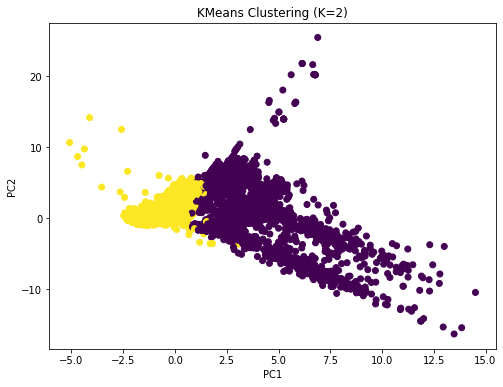

In [84]:
# create KMeans instance with the optimal cluster we indentified 
kmeans = KMeans(n_clusters=2, random_state=42)

# fit the model on your PCA-transformed DataFrame with 20 variables
kmeans.fit(pca_data)

# labels for each data of the point
labels = kmeans.labels_

# visualize the clusters using by using PCA1, PCA2
plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans Clustering (K=2)')
plt.show()

### DBSCAN

Here, we opted to use DBSCAN as our comparative clustering method since it is a suitable option for our case, given its efficient handling of large datasets and its ability to cluster data points with complex shapes. We experimented with several epsilon values during the process, it was found that setting an epsilon value of 0.7 was optimal for our DBSCAN model.

The optimal eps value: 0.775


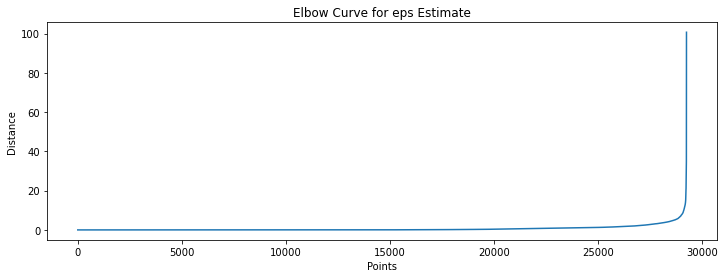

In [85]:
# fit nearest neighbors model
# several number of n_neighbors were tried 
nn = NearestNeighbors(n_neighbors=5)
nn.fit(pca_data)
distances, indices = nn.kneighbors(pca_data)

# sort distances and plot elbow curve
distances = np.sort(distances[:,4])
plt.figure(figsize=(12,4))
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('Distance')
plt.title('Elbow Curve for eps Estimate')

# estimate eps using elbow curve
eps_values = np.linspace(0.1, 1, num=5)
knee_values = []
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan.fit(pca_data)
    labels = dbscan.labels_
    if np.any(labels == -1):
        # Ignore noisy points
        num_clusters = len(set(labels)) - 1
    else:
        num_clusters = len(set(labels))
    knee = np.sum(labels == -1) / num_clusters
    knee_values.append(knee)
optimal_eps = eps_values[np.argmin(knee_values)]
print(f"The optimal eps value: {optimal_eps}")

Nonetheless, the DBSCAN clustering results below may indicate that our data do not have well-defined density-based clusters, since the rationale behind DBSCAN is based on identifying areas of high density and grouping nearby points into clusters. If our data is sparse and scattered in space, DBSCAN may not be effective in identifying meaningful clusters.

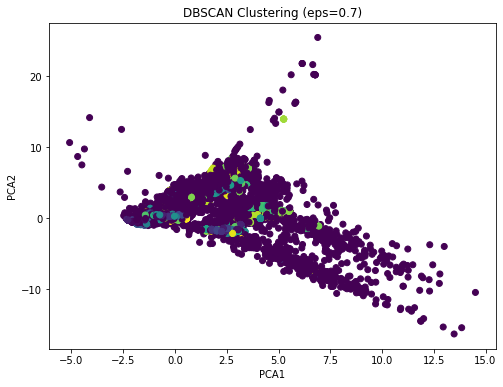

In [86]:
# fit DBSCAN model using optimal eps
dbscan = DBSCAN(eps=optimal_eps, min_samples=5)
dbscan.fit(pca_data)

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:,0], pca_data[:,1], c=dbscan.labels_)
plt.title('DBSCAN Clustering (eps=0.7)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

## 3.4 Exploring the segmentation attributes <a class="anchor" id="segmentation-attributes"></a>

To identify the most important features in the 2 segment groups revealed by k-means clustering, we visualized the correlations between the features and the most informative PC1 and PC2. We see that the variables allow_collaboration, public, colour_scheme_right, volume_right and fade_left have high correlations with PC1 and PC2.

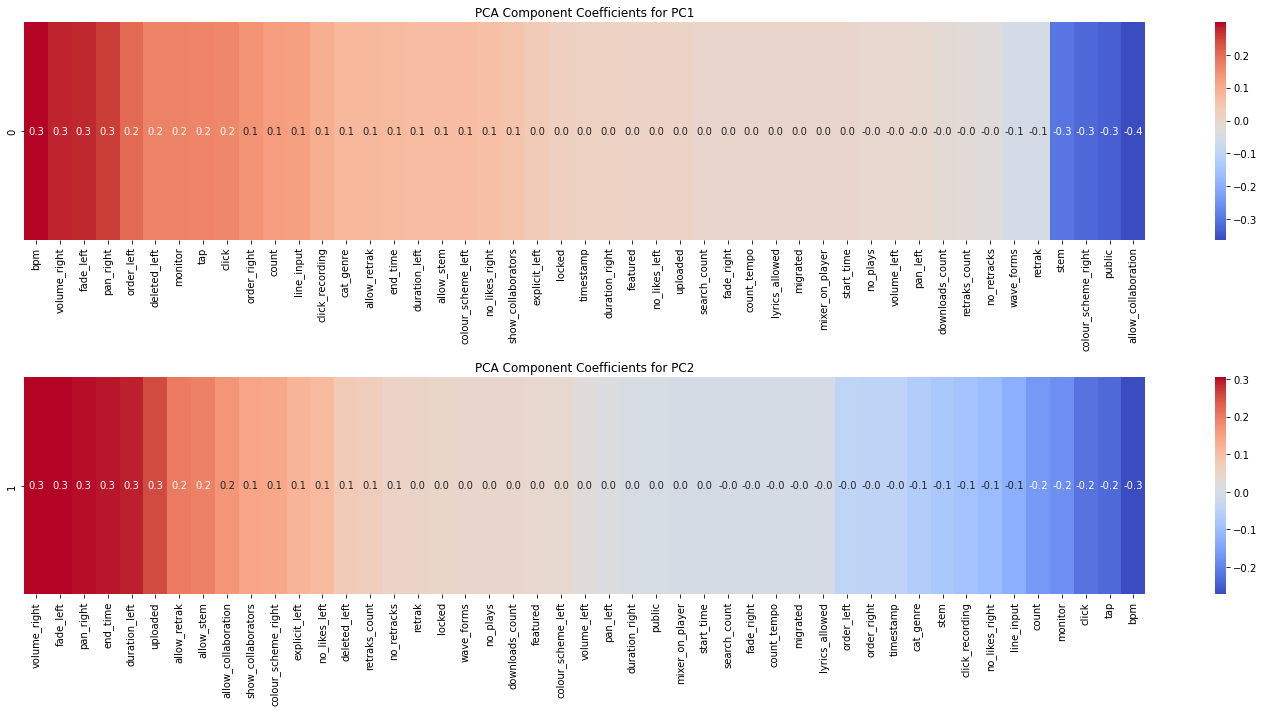

In [87]:
# get the feature names
features = list(df_imputed.columns)

# get the 1principal component coefficients for each feature
component_coefficients = pca.components_

# create a dataframe with the component coefficients and feature names
coefficients_df = pd.DataFrame(component_coefficients, columns=features)

# sort the dataframe by the values in the first row (PC1) and second row (PC2)
coefficients_df1 = coefficients_df.iloc[0, :].sort_values(ascending=False)
coefficients_df2 = coefficients_df.iloc[1, :].sort_values(ascending=False)

# create a figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

# plot the heatmap for PC1 in the top subplot
sns.heatmap(coefficients_df1.to_frame().T, cmap='coolwarm', annot=True, fmt='.1f', ax=axes[0])
axes[0].set_title('PCA Component Coefficients for PC1')

# plot the heatmap for PC2 in the bottom subplot
sns.heatmap(coefficients_df2.to_frame().T, cmap='coolwarm', annot=True, fmt='.1f', ax=axes[1])
axes[1].set_title('PCA Component Coefficients for PC2')

plt.tight_layout()
plt.show()

However, since interpreting clustering results based on PCA component coefficients can sometimes be complicated, and is not always straightforward by looking at the correlation matrix. Hence, we evaluate the performance of these factors by constructing a new k-mean cluster using the selected features and computing its silhouette score of the new clustering to see how well the data points are separated. The result turn out to be highly scored and as a result justify our previous argument.

In [88]:
# coefficients_df1
# only select the factors >0.3
coefficients_df1= abs(coefficients_df1).sort_values(ascending=False)
coefficients_df1[:3]

# coefficients_df2
# only select the factors >0.3
coefficients_df2= abs(coefficients_df2).sort_values(ascending=False)
coefficients_df2[:2]

# create a new df only important factors
df_influential = df_imputed[['allow_collaboration', 'public','colour_scheme_right','volume_right','fade_left']]

In [89]:
# run the k-mean by using only selected facotrs 
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=42)
clusters = kmeans.fit_predict(df_influential)

# evaluate the performance of the new clustering
# we use silhouette score again here 
# clustering is effective separating the data points into 2 groups
score = silhouette_score(df_influential, clusters)
print("The silhouette score is",round(score,2))

The silhouette score is 0.92


# 4. Conclusion  <a class="anchor" id="conclusion"></a>

Through a process of exploration and analysis, significant findings were revealed from the dataset of Trackd. The data indicates that the primary customer base consists of males between the ages of 20-29. Furthermore, the dataset shows a significant imbalance between creators and discoverers on the platform, with the former being three times more prevalent than the latter.

Moreover, the login rate and yearly joined creators have exhibited a gradual decline over time, and only a small fraction of users have adopted the paid service, accounting for merely 2% of the total user base.

Regarding the most popular genres on the platform, Hiphop and Rap, pop, and rock are the most commonly uploaded and listened to.

Lastly, the analysis of the data suggests that certain features, such as whether creators agree to collaborate and whether they have set their account as public, are crucial in determining the market segmentation for the company.